<img src="./images/Logos.jpg" title="Institutional Logos" width="70%">

# Heat Waves | Uncertainty and sensitivity 03: Integration Test of CLIMADA Impact Assessment with Copernicus Climate Change Service (C3S) data (V3)

### About

In this Jupyter Notebook, we delve into integrating CLIMADA's impact assessment capabilities with the heatwave datasets provided by the Copernicus Climate Change Service (C3S). We focus on unpacking the uncertainties and sensitivities within European heatwave data under the RCP 8.5 climate scenario. Utilizing CLIMADA's unsequa module, we explore various SALib sampling techniques to quantitatively ascertain the uncertainties inherent in each component of the impact model and evaluate the sensitivity of these components, thereby enhancing the precision and reliability of climate impact assessments.

### About U-CLIMADAPT

The U-CLIMADAPT project is a collaborative effort led by the Working Group "Impact of Climate Change." Its primary goal is to provide refined climate impact assessments tailored to specific requirements. To achieve this, it leverages the power of climate forecasts and projections from C3S's Climate Data Store (CDS), while also integrating Copernicus land-use and satellite data

### Discover New Possibilities

In U-CLIMADAPT, is dedicated to developing a comprehensive socioeconomic impact model chain using CLIMADA. Your feedback is invaluable as we shape this user-driven approach. Together, we address climate-related hazards like extreme heat, precipitation, agricultural drought, wind storms, and river floods, evaluating their impact on human health, agriculture, assets, and infrastructure. By actively collaborating with users like you from diverse sectors, including public authorities, industry, and academia, we ensure that our assessments are not only socio-economically relevant but also highly applicable to your needs.

### Tutorial Overview

Now, let's dive into the tutorial itself. We will guide you through the following steps:

- Set up the hazard, specifically focusing on heat stress.
- Estimate the exposure to heat stress in your chosen area.
- Define vulnerability and calculate the potential damage.

By following this tutorial, you will gain hands-on experience and unlock the potential of integrating CLIMADA with C3S data from Copernicus. Let's get started!

<br>

### Acknowledgments

- **Script Author**: [Dahyann Araya](https://github.com/DahyannAraya?tab=repositories)
- **Reviewer**: [Reviewer's](........)

### Import libraries

We will be working with data in NetCDF format. To best handle this data we will use libraries for working with multidimensional arrays, in particular Xarray. We will also need libraries for plotting and viewing data, in this case we will use Matplotlib and Cartopy.

In [2]:
# CDS API
import cdsapi

# Libraries for working with multidimensional arrays
import numpy as np
import xarray as xr

# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature


# Disable warnings for data download via API
import urllib3

urllib3.disable_warnings()
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning, module="shapely.predicates")
warnings.filterwarnings(
    "ignore", category=RuntimeWarning, module="shapely.constructive"
)

In [3]:
from climada import CONFIG

KEY = str(CONFIG.cds_api_key)

Here we specify a data directory in which we will download our data and all output files that we will generate:

In [4]:
import os

# Set the data directory within the user's Documents directory
DATADIR = os.path.join(os.path.expanduser("~/Documents"), "test_data")
os.makedirs(DATADIR, exist_ok=True)
print(f"Data will be saved in: {DATADIR}")

Data will be saved in: C:\Users\jimmy/Documents\test_data


In [5]:
current_directory = os.getcwd()

# Print the current directory
print("Current Directory:", current_directory)

Current Directory: C:\Users\jimmy\Documents\RA\CDS_Warm_up\CDS_Warm_Up


# Set a heat wave hazard 

In this first exercise, our goal is to analyze the heatwave hazard in Europe using the [heatwave days dataset from Copernicus](https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-heat-and-cold-spells?tab=overview). The dataset provides information for different future time periods and considers climate change scenarios, specifically RCP 8.5 and 4.6.

A bias-adjusted EURO-CORDEX dataset is utilized, offering temperature data from 1971 to 2100. By averaging the statistics over 30-year intervals, a smoothed mean time series spanning 1986 to 2085 is obtained. The dataset provides annual heatwaves days data with a resolution of 0.1° in latitude and longitude, equivalent to approximately 11 kilometers at the equator.

By conducting this exercise, we aim to gain insights into the long-term heatwave trends in Europe, taking into account future projections and climate change scenarios. This analysis can contribute to a better understanding of the potential impacts of heatwaves on the region and inform relevant mitigation and adaptation strategies.

### Inspect data

Now that we have downloaded the data, we can inspect it. We have requested the data in NetCDF format. This is a commonly used format for array-oriented scientific data. To read and process this data we will make use of the [Xarray](http://xarray.pydata.org/en/stable/) library. Xarray is an open source project and Python package that makes working with labelled multi-dimensional arrays simple and efficient. We will read the data from our NetCDF file into an [xarray.Dataset](https://xarray.pydata.org/en/stable/generated/xarray.Dataset.html).

In [6]:
import tarfile

tar_file = f"{DATADIR}/sis-heat-and-cold-spells.tar.gz"

# Print files names and extract
with tarfile.open(tar_file, "r:gz") as file:
    print(file.getnames())
    file.extractall(DATADIR)

# file.close()

['HWD_EU_health_rcp85_mean_v1.0.nc']


In [7]:
hwd_eu_rcp85_mean = f"{DATADIR}/HWD_EU_health_rcp85_mean_v1.0.nc"
ds = xr.open_dataset(hwd_eu_rcp85_mean)
ds

<xarray.Dataset> Size: 102MB
Dimensions:        (lat: 425, lon: 599, time: 100)
Coordinates:
    height         float64 8B ...
  * lat            (lat) float64 3kB 30.1 30.2 30.3 30.4 ... 72.2 72.3 72.4 72.5
  * lon            (lon) float64 5kB -24.9 -24.8 -24.7 -24.6 ... 34.7 34.8 34.9
  * time           (time) datetime64[ns] 800B 1986-01-01 ... 2085-01-01
Data variables:
    HWD_EU_health  (time, lat, lon) float32 102MB ...
Attributes:
    title:          Processed EURO-CORDEX future climate data for the health ...
    conventions:    CF-1.6
    project:        Copernicus Climate Change Service Sectoral Information Sy...
    source:         Processing of bias-corrected EURO-CORDEX data by VITO
    contact:        bd_rma@vito.be
    creation_date:  Mon Jun 24 12:30:06 2019
    institution:    VITO (https://vito.be/en)

In [8]:
hwd_eu_rcp85_mean = ds["HWD_EU_health"]  # Extract variable

In [9]:
# Shape and sizes
print(hwd_eu_rcp85_mean.shape)
print(hwd_eu_rcp85_mean.size)

(100, 425, 599)
25457500


See below what the annual heatwave days look like in 2010 and 2080. We can see that under this RCP8.5 scenario, heatwave days increase from a maximum of 18 days per year in 2010 in the territory under study to a maximum of 80 days in 2080.

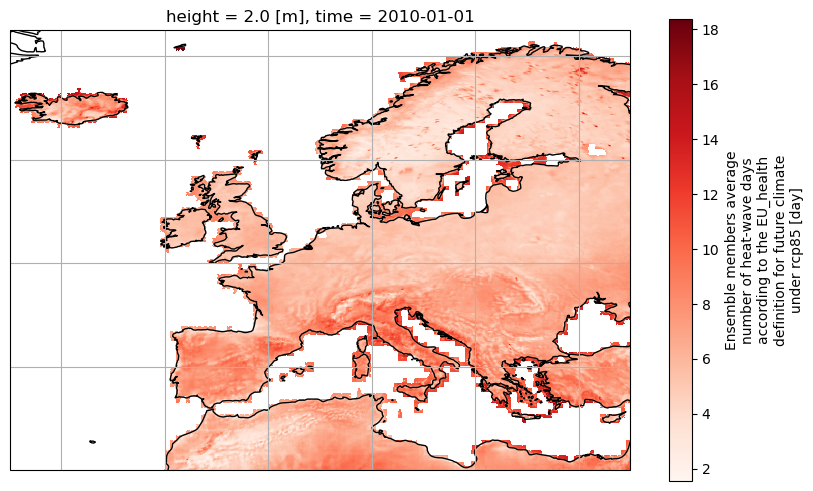

In [10]:
import cartopy.crs as ccrs
import pandas as pd

# Heat waves days in 2010
# Set projection to PlateCarree EPSG:4326
proj = ccrs.PlateCarree()

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": proj})

# Extract the years of the dataset
event_year = pd.DatetimeIndex(hwd_eu_rcp85_mean.time).year

# Find out the index of the target year
tidx = event_year.tolist().index(2010)

# Plot the data isel() method
hwd_eu_rcp85_mean.isel(time=tidx).plot(ax=ax, transform=ccrs.PlateCarree(), cmap="Reds")

# Add coastlines and gridlines
ax.coastlines()
ax.gridlines()
plt.show()

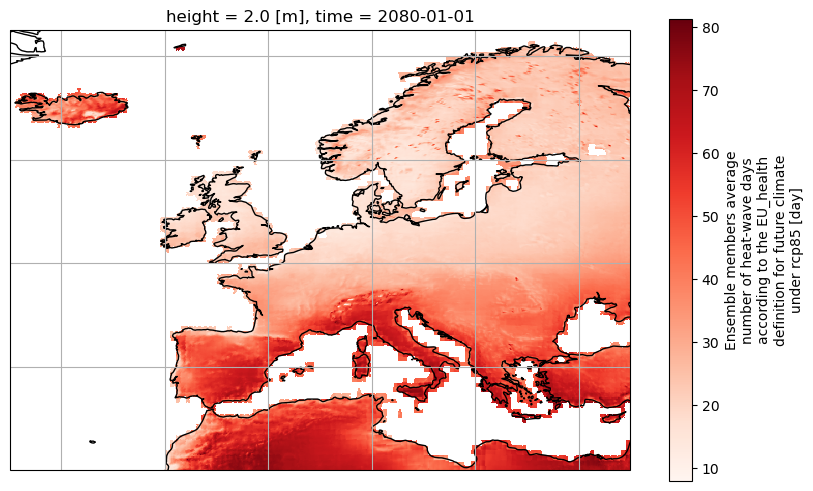

In [11]:
# Heat waves days in 2080

# Set projection to PlateCarree EPSG:4326
proj = ccrs.PlateCarree()

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": proj})

# Find out the index of the target year
tidx = event_year.tolist().index(2080)

# Plot the data isel() method
hwd_eu_rcp85_mean.isel(time=tidx).plot(ax=ax, transform=ccrs.PlateCarree(), cmap="Reds")

# Add coastlines and gridlines
ax.coastlines()
ax.gridlines()

# UNSEQUA 

The unsequa module in CLIMADA provides a comprehensive framework for conducting uncertainty and sensitivity analysis for various climate and disaster impact models. It allows users to define uncertain parameters through the InputVar class, perform Monte Carlo simulations, and analyze the impact of these uncertainties on the model's outputs.



Uncertainty measurement in the context of CLIMADA's unsequa module and similar frameworks involves quantifying the variability or unpredictability in model outputs due to uncertain inputs. This process typically includes the following key steps:

- Identification of Uncertain Inputs: The first step involves identifying the input parameters of the model that are uncertain. These could be related to hazard characteristics (e.g., intensity or frequency of events), exposure values (e.g., asset values), vulnerability curves, or adaptation measures costs and effectiveness. In CLIMADA's unsequa module, these inputs are encapsulated in the InputVar class.

- Defining Probability Distributions for Inputs: For each uncertain input, a probability distribution is assigned to describe the range and likelihood of its possible values. This distribution reflects the current understanding or best estimate of the variability of the input. Commonly used distributions include uniform, normal (Gaussian), beta, and log-normal distributions, which are chosen based on the nature of the input and available data.

- Sampling from Distributions: Sampling techniques are used to generate sets of input values from the defined probability distributions. These techniques include simple random sampling, Latin Hypercube Sampling (LHS), and more sophisticated methods like the Saltelli sampling method for Sobol' sensitivity analysis. The goal is to efficiently explore the input space to capture the effects of input uncertainties on the model outputs.

- Running the Model with Sampled Inputs: The model is run multiple times, each time with a different set of input values generated from the sampling process. This step produces a range of outputs corresponding to the variability in the inputs, allowing for the analysis of how input uncertainty propagates through the model.

- Analyzing the Output: The variability in the model outputs is then analyzed to quantify uncertainty. This can involve calculating statistical measures such as the mean, variance, or percentiles of the output distribution. Additionally, visualization techniques like histograms or probability density plots can help in understanding the distribution of the outputs.

- Sensitivity Analysis: To understand the contribution of each uncertain input to the output variability, sensitivity analysis is conducted. Methods like Sobol' sensitivity analysis can decompose the variance of the model output to attribute it to the variance in individual inputs or combinations of inputs. This helps in identifying the inputs that have the most significant impact on output uncertainty.

The unsequa module in CLIMADA facilitates this process by providing structured classes (InputVar, CalcImpact, CalcDeltaImpact, CalcCostBenefit) and methods to define uncertain inputs, perform sampling, run simulations, and analyze uncertainty and sensitivity of the outputs. This structured approach allows users to systematically quantify and understand the uncertainty in their risk assessments or cost-benefit analyses of adaptation measures, ultimately leading to more informed decision-making

__Here are the key concepts and functionalities within the unsequa module:__

a) Uncertainty and Sensitivity Analysis: Before using the module, it's crucial to understand the different types of uncertainties and their implications on modeling results. The module supports global uncertainty and sensitivity analysis, contrasting with the "one-factor-at-a-time" (OAT) method, which is less robust.

b) Unsequa Module Structure:

  - **InputVar**: Defines input uncertainty variables, which can be continuous or categorical. Users can specify a model variable as a function of uncertainty       input parameters and their probability distributions.
  - **CalcImpact**, **CalcDeltaImpact**, **CalcCostBenefit**: These classes calculate uncertainties for different outputs (e.g., impact, delta impact, cost-         benefit) using the defined InputVars.
  - **UncOutput**: Stores the results of uncertainty and sensitivity analysis, including the sampled data, calculated metrics, and sensitivity indices. It also          supports plotting methods for visualization.
    

c) Defining Uncertainty Variables (InputVar):

  - Uncertainty parameters are defined by specifying a function that returns a model variable and a dictionary of probability distributions for each input           parameter.
  - The module supports any probability distribution defined in scipy.stats.

d) Calculating Uncertainty and Sensitivity:

  - **The CalcImpact, CalcDeltaImpact, and CalcCostBenefit** classes are used to set input variables and compute uncertainty and sensitivity analysis.
        Users can specify non-default parameters for sampling methods, the number of samples, and sensitivity analysis methods to customize the analysis.

e) Visualization and Analysis:

  - **UncOutput** and its subclasses offer various plotting methods to visualize uncertainty distributions, sensitivity indices, and specific metrics like return periods or cost-benefit ratios.

>**Important:** To learn more about the calculation of uncertainty and sensitivity in CLIMADA, please consult the [UNSEQUA](https://climada-python.readthedocs.io/en/stable/tutorial/climada_engine_unsequa.html) documentation on CLIMADA's website. For additional information in [Kropf, C.M. et al. (2021)](https://eartharxiv.org/repository/view/3123/)

## Heat waves uncertainty and sensitivity analysis

This Jupyter tutorial will focus on understanding how uncertainty affects our model. While uncertainty can come from various sources, such as exposure data, hazard data, parameter data, or the hazard model, here we will focus on the vulnerability function and exposure parameters.

For this, we focus on calibrating heat waves' impacts and understanding the uncertainty and amplitude of possible outcomes. You can see below that we specified uncertainties within the mean damage degree (MDD) and the intensity of the impact function. To vividly illustrate these uncertainties, we introduced a sigmoid function that calculates MDD based on intensity, capturing the escalation of damage as heat waves intensify. Subsequently, an impact function with similar parameters to those in the Warm-Up exercise was used. Next, we generated exposure data tied to uncertainties, utilizing the LitPop class for designated countries with 'population' as the value unit.

We then outlined functions and distributions to adjust exposures and vulnerabilities in light of the identified uncertainties. This led to the initiation of a CalcImpact object, encapsulating the adjusted exposure and vulnerabilities alongside the hazard data. Finally, we showcased two sampling techniques, Latin and Saltelli, to generate samples of uncertainties. CLIMADA offers several sampling method alternatives that can be explored, here you have a brief explanition of them: 

<div class="alert alert-block alert-warning">
    <i class="fa fa-warning"></i>&nbsp;Important: The dummy function and the uncertainty parameters added in this documentation allows for the analysis of the relationship between population and heatwave days. This function and the parameters serve as a demonstration only; you should define your own functions according to your specific field of study. </div>

>**Important:** The sampling methods in UNSEQUA are part of the SALib library, a widely used library for conducting Sensitivity Analysis (SA) in scientific research. These methods are designed to efficiently sample the input space of a model to analyze how variations in model inputs contribute to changes in the output. Here's a brief explanation of each method:

>Saltelli: This method is an extension of the Sobol' sequence sampling, providing a way to estimate the total variance and Sobol sensitivity indices. It generates samples by systematically varying each input parameter, allowing for the estimation of both main effects and interaction effects among the parameters. It is particularly effective for global sensitivity analysis and is one of the most commonly used methods for variance-based sensitivity analysis.

>FAST Sampler (Fourier Amplitude Sensitivity Testing): The FAST method is a frequency domain analysis technique. It assesses sensitivity by transforming a time or space domain model into the frequency domain using Fourier transforms. It is particularly useful for models with a large number of inputs, as it can efficiently compute first-order sensitivity indices with fewer model evaluations than some other methods.

>Latin Hypercube Sampling (LHS): LHS is a statistical method for generating a sample of plausible collections of parameter values from a multidimensional distribution. It efficiently covers the entire range of input variables by dividing each variable's range into intervals of equal probability. It ensures every part of the range is sampled without overlaps, which is beneficial for exploring the input space thoroughly with a relatively small number of samples.

>Morris Method: Also known as the Morris One-At-A-Time (OAT) method, this technique involves systematically and incrementally varying one input parameter at a time while keeping the others fixed to determine the effect of each parameter on the output. It's a qualitative method to identify non-linearities and interactions between parameters, providing measures of elementary effects that indicate parameter importance.

>DGSM (Derivative-based Global Sensitivity Measures): This approach uses the derivatives of the model output with respect to its inputs to assess sensitivity. It's particularly useful for identifying parameters that have a significant impact on the output across the entire input space, allowing for a quick screening of parameters to focus more detailed analysis on those that are most influential.

>FF (Fractional Factorial): This method involves running a subset of all possible combinations of parameter settings, using a fraction of the full factorial design. It's a type of experimental design that can identify the most important factors and their interactions in models with a large number of inputs, reducing the total number of simulations required.

https://climada-python.readthedocs.io/en/stable/tutorial/climada_engine_unsequa.html#uncoutput
https://climada-python.readthedocs.io/en/stable/tutorial/climada_engine_unsequa_helper.html#impactfuncset

<div class="alert alert-block alert-warning">
    <i class="fa fa-warning"></i>&nbsp;Important: The dummy function used in this documentation allows for the analysis of the relationship between exposure and the hazard. This function and parameters serves as a demonstration only; you should define your own functions according to your specific field of study.
</div>

### Impact function
The function `sigmoid_mdd` calculates the Mean Damage Degree (MDD) for a given hazard intensity using a sigmoid function. The sigmoid function is often used to model situations where the response (in this case, damage) gradually increases with the stimulus (hazard intensity).

### Parameters
- **intensity**: The hazard intensity, which can vary over a range (e.g., from 0 to 365 days in the case of heatwaves).
- **T (Threshold)**: The intensity value where the sigmoid function inflects, meaning the point where the increase in MDD is most rapid. Default is 3.
- **k (Steepness)**: The steepness of the sigmoid curve. A larger value of `k` results in a steeper curve, meaning the transition from low to high MDD happens more abruptly. Default is 0.1.
- **maxMDD**: The maximum possible value of MDD. Default is 1, meaning the damage degree ranges from 0 to 1.

### Mathematical Expression
The function uses the logistic (sigmoid) function, which is given by the formula:
$$
\text{MDD} = \frac{\text{maxMDD}}{1 + e^{-k \cdot (\text{intensity} - T)}}
$$

This formula describes an S-shaped curve that smoothly transitions from 0 to `maxMDD`.

### Appliction
- When the intensity is much lower than the threshold `T`, the term $-k \cdot (\text{intensity} - T)$ is positive and large, making $e^{-k \cdot (\text{intensity} - T)}$ large. Hence, the denominator is large and the MDD is close to 0.
- When the intensity is much higher than the threshold `T`, the term $-k \cdot (\text{intensity} - T)$ is negative and large, making $e^{-k \cdot (\text{intensity} - T)}$ close to 0. Thus, the denominator approaches 1 and the MDD approaches `maxMDD`.
- Around the threshold `T`, the function transitions smoothly from low to high values, with the steepness controlled by `k`.

In [27]:
from climada.hazard import Hazard
from climada.entity import ImpactFunc, ImpactFuncSet, LitPop
from climada.engine import Impact
from climada.engine.unsequa import InputVar, CalcImpact
import numpy as np
import scipy.stats as sp
import matplotlib.pyplot as plt
import pandas as pd
import copy
import time


# Define bounds for adding uncertainties
bounds_mdd = [0.7, 1.3]  # -30% to +30% uncertainty on the mdd
bounds_paa = None  # No uncertainty in the paa
bounds_impfi = [-10, 10]  # -10 to +10 uncertainty on the intensity


# Sigmoid function for MDD calculation
# T: The threshold value where the sigmoid function inflects
# k: The steepness of the curve
def sigmoid_mdd(intensity, T=3, k=0.1, maxMDD=1):
    """Calculates a sigmoid mean damage degree (MDD) based on intensity."""
    return maxMDD / (1 + np.exp(-k * (intensity - T)))


# Create the ImpactFuncSet object with sigmoid MDD
if_heatwave = ImpactFunc()
if_heatwave.haz_type = "Heat_waves_days"
if_heatwave.id = 1
if_heatwave.name = "Heat wave impact function"
if_heatwave.intensity_unit = "days"
if_heatwave.intensity = np.arange(0, 366, 1)
if_heatwave.mdd = sigmoid_mdd(if_heatwave.intensity)
if_heatwave.paa = np.ones(366)
if_set_base = ImpactFuncSet([if_heatwave])


# Hazard
# Load hazard data
hazard = Hazard.from_xarray_raster_file(
    f"{DATADIR}/HWD_EU_health_rcp85_mean_v1.0.nc",
    hazard_type="Heat_waves_days",
    intensity_unit="days",
    intensity="HWD_EU_health",
    coordinate_vars=dict(event="time", longitude="lon", latitude="lat"),
)
hazard.event_name = list(map(lambda x: pd.Timestamp(x).isoformat(), hazard.event_name))

# Calculate the mean number of heatwave days for each event across all cells
mean_heatwave_days_per_event = np.mean(hazard.intensity.toarray(), axis=1)

# Normalize these means to get relative frequencies for each event
# **This assumes that the event with the most heatwave days is the most frequent
relative_frequencies = mean_heatwave_days_per_event / np.sum(
    mean_heatwave_days_per_event
)

# Assign these relative frequencies to the hazard object's frequency attribute
hazard.frequency = relative_frequencies


# Exposure
# Assign the centroids of hazard events to the adjusted exposure data
exp_base = LitPop.from_countries(
    ["CHE", "DEU"], res_arcsec=120, fin_mode="pop", exponents=(2, 1)
)
exp_base.assign_centroids(hazard)
exp_base.value_unit = "Population"  # Set the value_unit attribute


# Define functions to modify exposures and hazards based on uncertainty parameters
def exp_func(x_exp, exp_base=exp_base):
    # Instead of trying to subscript exp_base, directly work with its GeoDataFrame
    exp = exp_base.copy()
    exp.gdf["value"] *= x_exp
    return exp


exp_distr = {
    "x_exp": sp.norm(1, 0.2)  # Normal distribution for hazard intensity scaling
}


# Add the impact function id to the exposures
[haz_type] = if_set_base.get_hazard_types()
[haz_id] = if_set_base.get_ids()[haz_type]
hazard_type = "Heat_waves_days"
# Create the new column 'impf_' + hazard_type and assign the hazard id to it
exp_base.gdf["impf_" + hazard_type] = haz_id


# Create InputVar instances
exp_iv = InputVar(exp_func, exp_distr)


# Create the InputVar object for the vulnerability function with uncertainties
vuln_iv = InputVar.impfset(
    impf_set_list=[if_set_base],
    bounds_impfi=bounds_impfi,
    bounds_mdd=bounds_mdd,
    bounds_paa=bounds_paa,
    haz_id_dict={"Heat_waves_days": [1]},
)


# Initialize CalcImpact object for uncertainty analysis with adjusted exposure
calc_imp = CalcImpact(exp_iv, vuln_iv, hazard)


# Generate samples and calculate impacts with uncertainty
# Here, you have two sampling options to test: Latin and the default Saltelli. In Saltelli, N=2**7 sets the base number of samples. The ** symbol is the exponentiation operator,
# meaning 2**7 calculates 2 raised to the power of 7, which equals 128. Meanwhile, sampling_kwargs={'skip_values': 8**8} specifies an argument to skip values, with 8 raised to
# the power of 8 equating to 16,777,216. Thus, 16,777,216 values are skipped in the sequence before starting to take samples.
sample_output_imp_non_linear = calc_imp.make_sample(N=1000, sampling_method="latin")
# sample_output_imp_non_linear = calc_imp.make_sample(N=2**7, sampling_kwargs={"skip_values": 8**8})

# To prepare for later analysis, we're computing the eai_exp metric distribution. This intensive calculation is sped up using multiple processes, timed using Python's time module.
# For large datasets, a single process may be more practical to avoid multi-processing overhead.
start = time.time()
output_imp_non_linear = calc_imp.uncertainty(
    sample_output_imp_non_linear,
    rp=[2, 20, 50],
    calc_eai_exp=True,
    calc_at_event=True,
    processes=4,
)
end = time.time()

time_passed = end - start
print(f"Time passed with pool: {time_passed}")

2024-07-17 11:20:36,663 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2024-07-17 11:20:36,686 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2024-07-17 11:20:36,710 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2024-07-17 11:20:36,733 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2024-07-17 11:20:36,745 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2024-07-17 11:20:36,768 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2024-07-17 11:20:36,791 - climada.entity.exposures.litpop.gpw_populati

The image displays the original impact function for heatwaves for 50 random samples. The impact function is plotted with the mean damage degree (MDD) and the potentially affected area (PAA). The blue line represents the original MDD, while the red line shows the original PAA.

The grey lines represent the MDD of 50 samples, each generated by varying the MDD and the intensity of the heat waves within a range (the bounds of uncertainty). These modifications simulate how different assumptions within the specified uncertainty bounds can affect the impact function. The wide spread of grey lines illustrates the potential variability in the impact due to changes in MDD and intensity shift, emphasizing the range of possible outcomes when factoring in uncertainties.

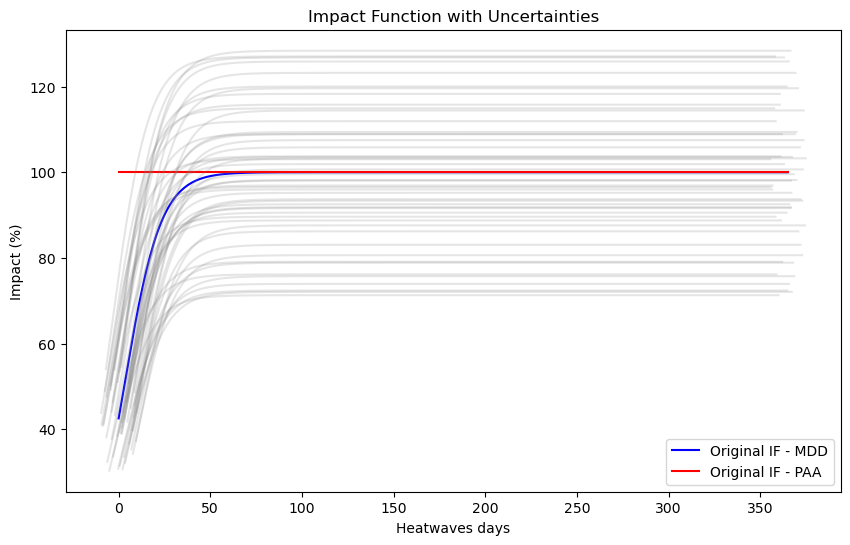

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from climada.entity import ImpactFunc

# Number of samples to generate
n = 50

# Plot the original impact function
fig, ax = plt.subplots(figsize=(10, 6))

# Manually plot the MDD and PAA for the original impact function
ax.plot(if_heatwave.intensity, if_heatwave.mdd * 100, "b", label="Original IF - MDD")
ax.plot(if_heatwave.intensity, if_heatwave.paa * 100, "r", label="Original IF - PAA")

# Generate and plot n modified impact functions
for _ in range(n):
    # Randomly sample mdd_factor and intensity_shift within their bounds
    mdd_factor = np.random.uniform(bounds_mdd[0], bounds_mdd[1])
    intensity_shift = np.random.uniform(bounds_impfi[0], bounds_impfi[1])

    # Apply the random samples to modify the base impact function
    modified_intensity = if_heatwave.intensity + intensity_shift
    modified_mdd = if_heatwave.mdd * mdd_factor

    # Plot the modified MDD curve with low opacity
    ax.plot(
        modified_intensity,
        modified_mdd * 100,
        color="grey",
        alpha=0.2,
        label="_nolegend_",
    )

# Enhance plot
ax.set_xlabel("Heatwaves " + if_heatwave.intensity_unit)
ax.set_ylabel("Impact (%)")
ax.set_title("Impact Function with Uncertainties")
ax.legend()

# Show the plot
plt.show()

### Explore Uncertainty

Here can be seen that the output include the Aggregated Annual Impact (`aai_agg`), the Frecuency Curve (`freq_curve`) and the information per event as `at_event`

In [29]:
# All the computed uncertainty metrics attribute
output_imp_non_linear.uncertainty_metrics

['aai_agg', 'freq_curve', 'eai_exp', 'at_event']

The `get_uncertainty()` method provides a summary of the analysis on how uncertainties in the input parameters influence the model's outputs. In the resulting data, the first column, `aai_agg`, is followed by columns representing different return periods. This data showcases the variability in the model's predictions, reflecting the impact of uncertainties on the estimated annual aggregated impact (`aai_agg`) and the expected damages for specific return periods (`rp2`, `rp20`, `rp200`). Each row corresponds to a different sample scenario, illustrating the range of possible outcomes due to the inherent uncertainties in the input data.

Values from 0 to 100 correspond to at_event data we will use this data at the end of this script to plot the sensitivity.

In [30]:
print(output_imp_non_linear.get_uncertainty())
np.shape(hazard.intensity)

          aai_agg           rp2          rp20          rp50         0  \
0    4.692203e+07  4.882934e+07  5.679827e+07  5.696452e+07  0.025142   
1    6.190533e+07  6.428396e+07  6.729213e+07  6.730839e+07  0.030547   
2    8.016561e+07  8.254821e+07  8.768441e+07  8.776380e+07  0.039973   
3    1.122352e+08  1.166809e+08  1.216294e+08  1.216488e+08  0.055286   
4    5.455015e+07  5.609923e+07  5.927514e+07  5.932438e+07  0.027096   
..            ...           ...           ...           ...       ...   
995  3.453897e+07  3.586415e+07  4.085539e+07  4.095743e+07  0.018217   
996  4.982143e+07  5.011979e+07  6.444428e+07  6.475799e+07  0.028609   
997  9.800951e+07  1.015219e+08  1.109371e+08  1.110809e+08  0.049883   
998  6.851896e+07  7.041602e+07  7.585998e+07  7.596594e+07  0.034670   
999  5.305919e+07  5.517743e+07  6.369162e+07  6.386824e+07  0.028265   

            1         2         3         4         5  ...            90  \
0    0.061829  0.278772  0.028445  0.105007  0.

(100, 254575)

In [31]:
# One uncertainty dataframe
output_imp_non_linear.get_unc_df("aai_agg").tail()

,aai_agg
995,3.453897e+07
996,4.982143e+07
997,9.800951e+07
998,6.851896e+07
999,5.305919e+07


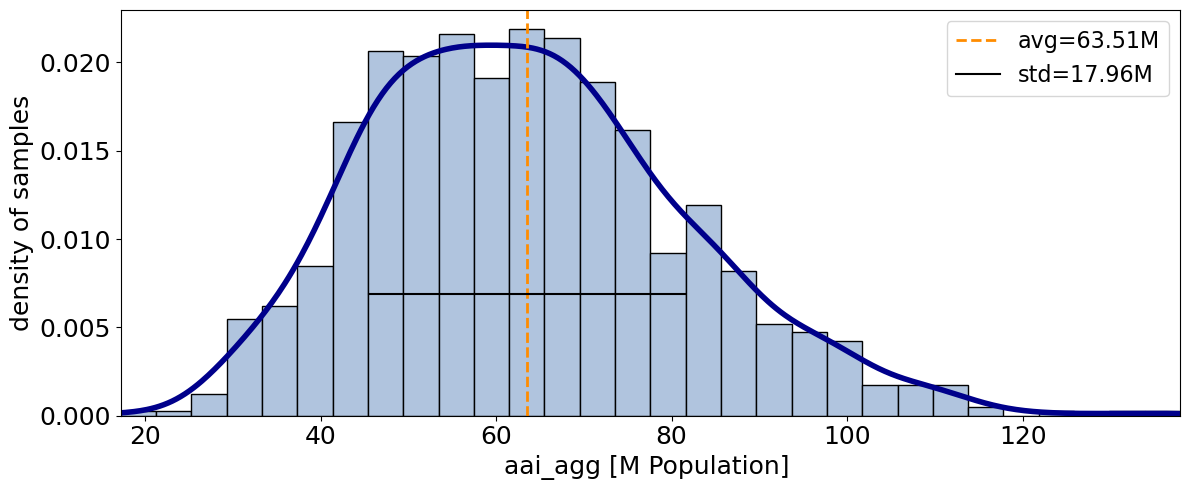

In [32]:
# Range of aai_agg
output_imp_non_linear.plot_uncertainty(metric_list=["aai_agg"], figsize=(12, 5));

We can examine samples of uncertainty parameters or plot them, starting with `x_exp`, the scaling factor that adjusts exposure values, signifying the degree to which original values are either amplified or diminished. Following this, `IFi` represents modifications to the intensity of the impact function, capturing the alterations in damage estimations resulting from fluctuating hazard intensities. Lastly, `MDD`, or Mean Damage Degree, is a measure denoting the average damage at a given intensity level of the hazard.

In [33]:
output_imp_non_linear.get_samples_df().tail()

,x_exp,IFi,MDD
995,0.563807,0.735458,0.955740
996,0.906819,9.938175,1.115434
997,1.314164,-2.547870,1.085858
998,1.140898,-5.873893,0.822517
999,1.050603,1.950143,0.812655


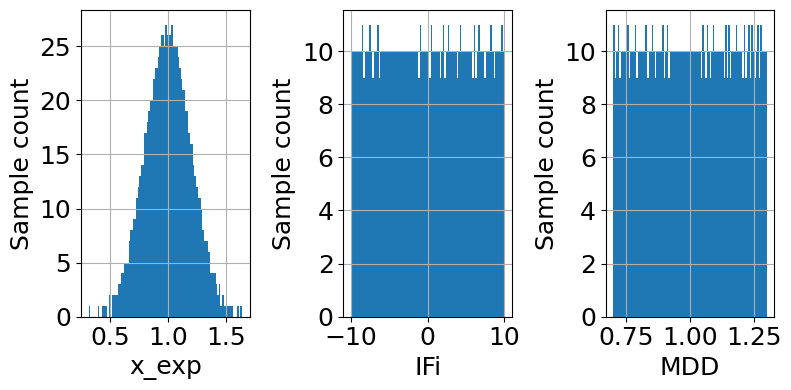

In [34]:
output_imp_non_linear.plot_sample(figsize=(8, 4));

Below, we plot four distribution plots, each representing the uncertainty in the predicted impact of heat waves on the population. 
- The first plot (top left) represents the mean annual impact (aai_agg), with a mean impact (avg) of about 63.65 million people (the dashed vertical lines in each graph represent the mean values, visually indicating the centre of the distributions) and a standard deviation (std) of about 18.38 million. The distribution appears normal around the mean, indicating that most of the simulations cluster around this central value with a dispersion dictated by the standard deviation.

- The second graph (top right) illustrates the 2-year return period (rp2), showing a mean impact on about 65.81 million people with a standard deviation of about 19.01 million. This graph suggests a similar dispersion of results as the first, with most of the results close to the mean value.

- The third graph (bottom left) shows the 20-year return period (rp20), with a mean of 73.44 million people affected and a standard deviation of 18.89 million. This suggests a slightly higher average impact than rp2, possibly indicating that more extreme events occurring less frequently may affect more people.
  
- The fourth graph (bottom right) presents the 50-year return period (rp50), with a mean of 73.58 million people affected and a standard deviation of 18.89 million. Like rp20, it reflects the results of less frequent but more severe events.

>**Important:** Due to the random nature of the sampling process, it is normal to have a slightly different summary statistics every time you run the uncertainty analysis.

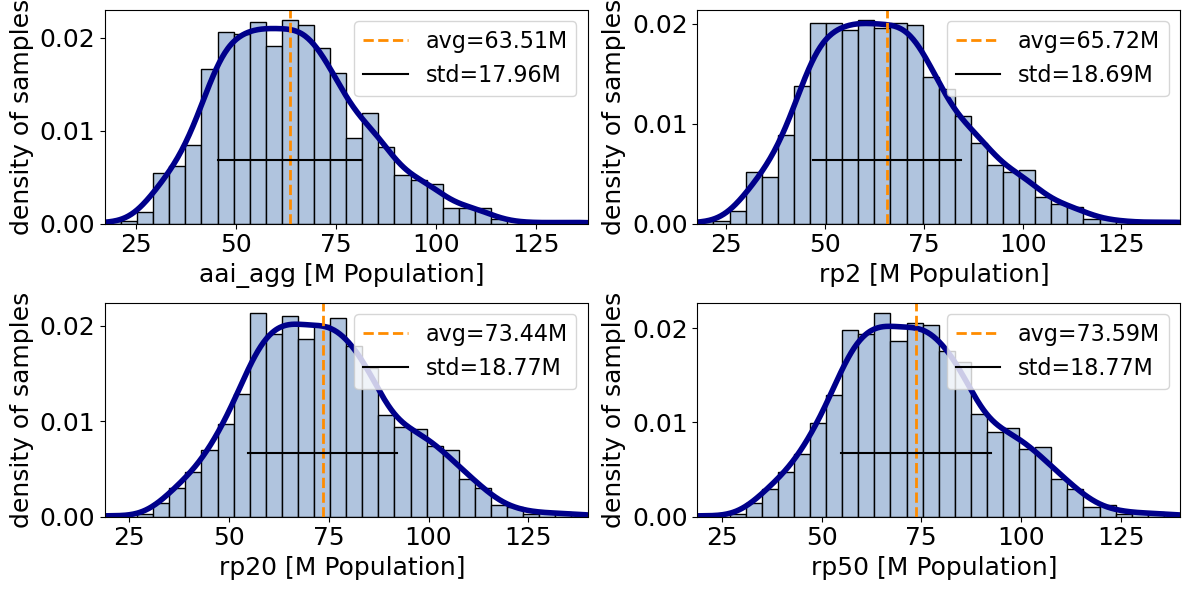

In [35]:
output_imp_non_linear.plot_uncertainty(figsize=(12, 6));

Here, the first graph (on the left) is a frequency graph illustrating the return period of heatwaves in relation to the affected population. The x-axis shows the impact of the affected population (in millions), while the y-axis indicates the return period in years. The graph shows three distributions in different colours, each representing different scenarios or conditions under which the impact assessments were conducted. For example, they could represent different climate models, uncertainty ranges or other variables that affect heat wave impacts.

The second graph (on the right) is a line depicting the population impact (in millions) for different heatwave return periods (in years). The lines represent different percentiles of impact: the solid line denotes the median (50th percentile), the upper dashed line is the 95th percentile, and the lower dashed line is the 5th percentile. This visualisation helps to understand the probability of heat waves occurring in the population. This plot helps to understand the likelihood and magnitude of extreme events, for example, how often severe heat waves could occur and how many people could be affected.

c:\users\jimmy\documents\ra\climada_python\climada\engine\unsequa\unc_output.py:710: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower right')


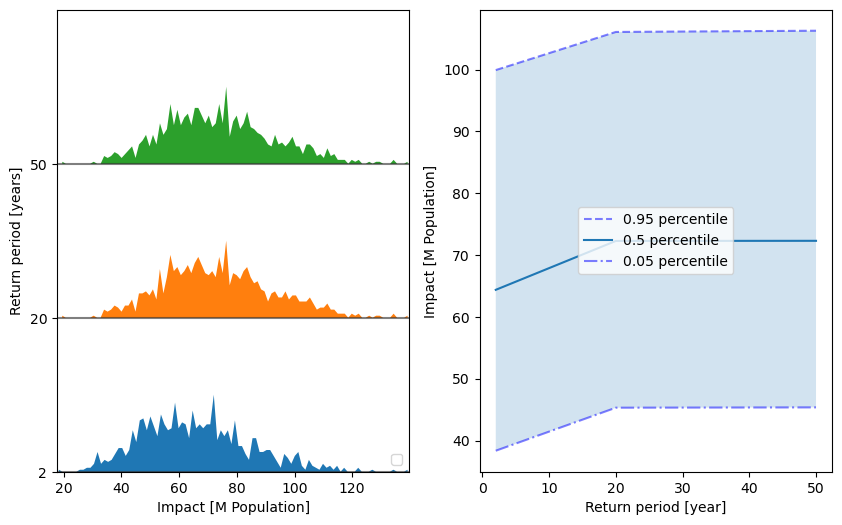

In [36]:
# Specific plot for the return period distributions
output_imp_non_linear.plot_rp_uncertainty(figsize=(10, 6));

### Explore Sensitivity

We will now analyse the sensitivity of the parameters in the model. 

In [55]:
output_imp_sensitivity = calc_imp.sensitivity(output_imp_non_linear)

output_imp_sensitivity.sensitivity_metrics

2024-07-17 13:41:35,834 - climada.engine.unsequa.unc_output - WARNING - The chosen combination of sensitivity method (latin) and sampling method (sobol) does not correspond to the recommendation of the salib pacakge.
 https://salib.readthedocs.io/en/latest/api.html


C:\Users\jimmy\anaconda3\envs\climada_dev\lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
C:\Users\jimmy\anaconda3\envs\climada_dev\lib\site-packages\pandas\core\dtypes\common.py:1636: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  npdtype = np.dtype(dtype)
C:\Users\jimmy\anaconda3\envs\climada_dev\lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
C:\Users\jimmy\anaconda3\envs\climada_dev\lib\site-packages\pandas\core\dtypes\common.py:1636: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The

['aai_agg', 'freq_curve', 'eai_exp', 'at_event']

The results from `output_imp.get_sens_df('aai_agg').tail()` indicate the second-order sensitivity indices (interaction effects) for the `aai_agg` metric, which stands for the average annual impact, often measured in terms of affected population or economic loss.
- **si**: Indicates the type of sensitivity index, here S2_conf, which represents the second-order confidence index. It quantifies the influence of an interaction between two parameters on the output variability.
- **param and param2**: These columns list the names of the input parameters being analyzed for interaction effects.
- **aai_agg**: This column would contain the calculated second-order sensitivity index for the interaction of the parameters specified in the param and param2 columns concerning the average annual impact.
The NaN values denote that the sensitivity index could not be calculated for the interaction of those particular parameters. This might be due to insufficient or inconclusive data, or the model does not support calculating an interaction effect for those specific pairs of parameters.

The results showcase which parameter interactions have been calculated and their impact on the `aai_agg` metric. For example, for the interaction between `IFi` (intensity function) and `MDD` (mean damage degree), there is a calculated index of 0.32249 (**Note**: it is normal to obtain a different value, but it should not deviate too much from it). This value suggests a moderate level of influence of the interaction between these two parameters on the variability of the average annual impact, meaning changes in these two factors could lead to significant changes in this output.

In [56]:
output_imp_sensitivity.get_sens_df("aai_agg").tail()

,si,param,param2,aai_agg
25,S2_conf,IFi,IFi,NaN
26,S2_conf,IFi,MDD,0.380091
27,S2_conf,MDD,x_exp,NaN
28,S2_conf,MDD,IFi,NaN
29,S2_conf,MDD,MDD,NaN


The results from `output_imp.get_sensitivity('S1')` show the first-order sensitivity indices (S1) for different parameters with respect to various metrics. The first-order sensitivity index measures the direct effect of each input parameter on the output variability when varied on its own.
- **si**: Sensitivity index type, S1 indicates the first-order sensitivity index. It can be change to S2.
- **param**: The input parameter being analyzed.
- **param2**: In this context, None signifies that the sensitivity index is calculated for a single parameter at a time without considering interactions with other parameters.
- **aai_agg, rp2, rp20, rp50**: The columns representing the average annual impact (`aai_agg`) and return periods (`rp2`, `rp20`, `rp50`) in millions of the affected population. The return period values represent the likelihood of a certain event happening within a given number of years.
The numerical values indicate how much these outputs are expected to change in response to changing each input parameter. A negative value implies that as the parameter increases, the impact metric decreases, which might suggest an inversely proportional relationship.

Here's a breakdown of the specific results:
For `x_exp` (exposure scaling factor), the S1 indices are negative across all metrics, suggesting that as the exposure increases, the impacts (in terms of aai_agg and return periods) decrease.<br>
For `IFi` (impact function intensity), the S1 indices are also negative but have smaller absolute values than `x_exp`, indicating a lesser but still significant inverse effect on the impacts.<br>
For `MDD` (mean damage degree), the indices are negative and show a more significant influence on the `rp20` and `rp50` than on the `aai_agg` and `rp2`, suggesting that changes in MDD have a more substantial impact on the longer return period values.<br>
Overall, these results can be used to understand which parameters have the most significant direct effects on the outputs and help prioritize which parameters require more accurate estimation or more robust data collection methods.

In [ ]:
output_imp_sensitivity.get_sensitivity("S1")

In [58]:
output_imp_sensitivity.get_largest_si(salib_si="S2")

c:\users\jimmy\documents\ra\climada_python\climada\engine\unsequa\unc_output.py:400: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_si_idx = si_df_num.idxmax().to_numpy()


,metric,param,param2,si
0,aai_agg,IFi,MDD,0.120454
1,rp2,IFi,MDD,0.129015
2,rp20,IFi,MDD,0.128999
3,rp50,IFi,MDD,0.128784
4,0,IFi,MDD,0.133130
...,...,...,...,...
45862,95,IFi,MDD,0.129465
45863,96,IFi,MDD,0.129766
45864,97,IFi,MDD,0.129477
45865,98,IFi,MDD,0.128977


The sensitivity index "S1" reflects the effect of each input parameter when varied individually, without interaction with other parameters. Here is a breakdown of the graphs:

On the left is a bar graph showing the sensitivity index (SI) for the input parameter 'aai_agg'. The boxes represent the range of S1 index values for the parameters 'x_exp', 'IFi', and 'MDD'; the lines (whiskers) indicate the variability or uncertainty in these values. The further the box moves away from zero, the more influential that parameter is considered to be.

On the right are three overlapping bar charts showing the sensitivity index (SI) for three return periods (rp2, rp20, rp50). Each return period has its SI for the same input parameters: 'x_exp', 'IFi', and 'MDD'. These return periods correspond to events expected to occur once every 2, 20, and 50 years, respectively.

rp2 (Blue bars): The closer the bars are to zero, the less impact that parameter has on the output for this return period. A bar extending below zero indicates a negative relationship between the parameter and the output, while a bar above zero indicates a positive relationship.

rp20 (Orange bars): These bars correspond to events with a return period of 20 years. The sensitivity index for this more extended return period can show different magnitudes or directions compared to the rp2, indicating that the impact of certain parameters might become more or less significant as the return period changes.

rp50 (Green bars): These bars are associated with a return period of 50 years, representing rarer and potentially more severe events.

<div class="alert alert-block alert-warning">
    <i class="fa fa-warning"></i>&nbsp;Sampling processes, especially those that incorporate randomness or stochastic elements, can lead to slightly different estimates each time they are run. This variability is expected and is part of what makes each simulation unique. It's also why such processes are typically run multiple times to get a more robust understanding of the risks by looking at the spread or distribution of the results. </div>

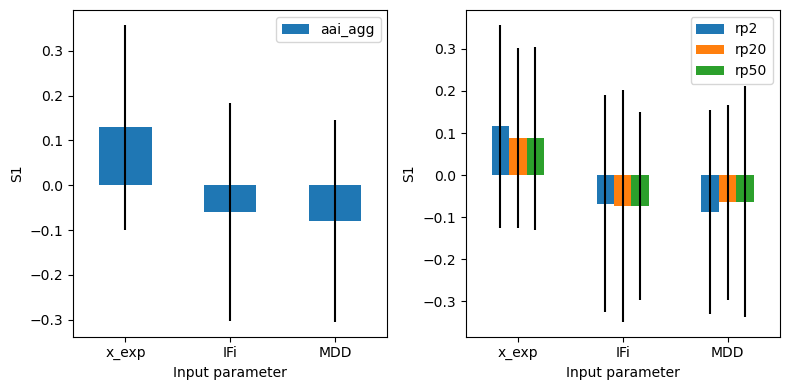

In [59]:
# Default for 'sobol' is to plot 'S1' sensitivity index.
output_imp_sensitivity.plot_sensitivity(salib_si="S1", figsize=(8, 4));

Here, we employ the total sensitivity index (ST) as a more comprehensive measure than the first-order sensitivity (S1). The ST index precisely quantifies the impact of each input parameter on the output variance, considering its individual effect and interaction with all other parameters.

The bars represent the ST index for different input parameters (such as `x_exp`, `IFi`, `MDD`) on the left and their impact on return periods (`rp2`, `rp20`, `rp50`) on the right. A higher ST value indicates that an input parameter has a greater influence on the variance of the output. This includes not only the direct effect of changing that parameter but also how changes in that parameter interact with changes in other parameters. The vertical lines (or "whiskers") extending from the bars provide a clear indication of the range or uncertainty of the ST index estimate. A long whisker suggests that there is greater uncertainty associated with the total sensitivity estimate for that parameter.

From this plot, one can deduce which parameters have the most significant impact on the model results, including all interaction effects, and therefore where to focus attention when considering model fits or robustness checks.

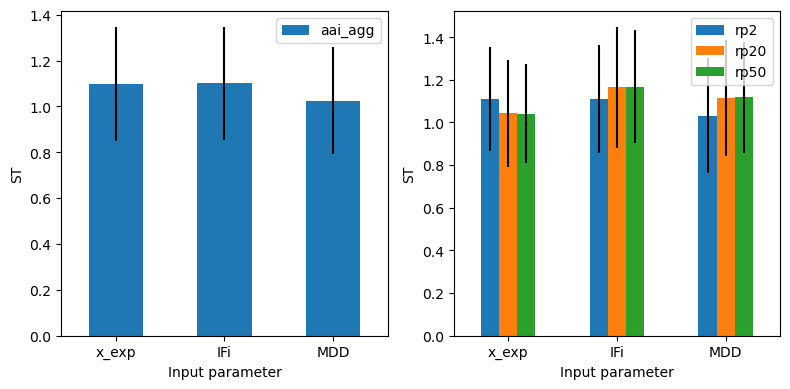

In [46]:
output_imp_sensitivity.plot_sensitivity(salib_si="ST", figsize=(8, 4));

A second-order sensitivity (S2) analysis matrix for metrics such as `aai_agg` and return periods (`rp2`, `rp20`, `rp50`) is shown below. S2 indices measure how the interactions between pairs of input parameters influence the output variance.

Each cell in the matrix corresponds to the interaction between the input parameters along the row and column. The value inside each cell represents the S2 index for that particular pair of parameters. A higher value indicates a stronger interaction effect on the output's variance. Then the ± values represent the uncertainty or confidence intervals around the calculated S2 index. Cells with `nan` indicate that there is no interaction effect measured, often because it refers to a parameter's interaction with itself, which is not defined in this context. The colours indicate the magnitude of the S2 indices, with different colours corresponding to various ranges of values. Darker or more intense colours represent higher values.

Analysis of these matrices allows us to understand not only the individual impact of each parameter on the outcome (as shown in the first-order sensitivities) but also how pairs of parameters work together to affect the outcome in complex models where interactions between factors are significant.

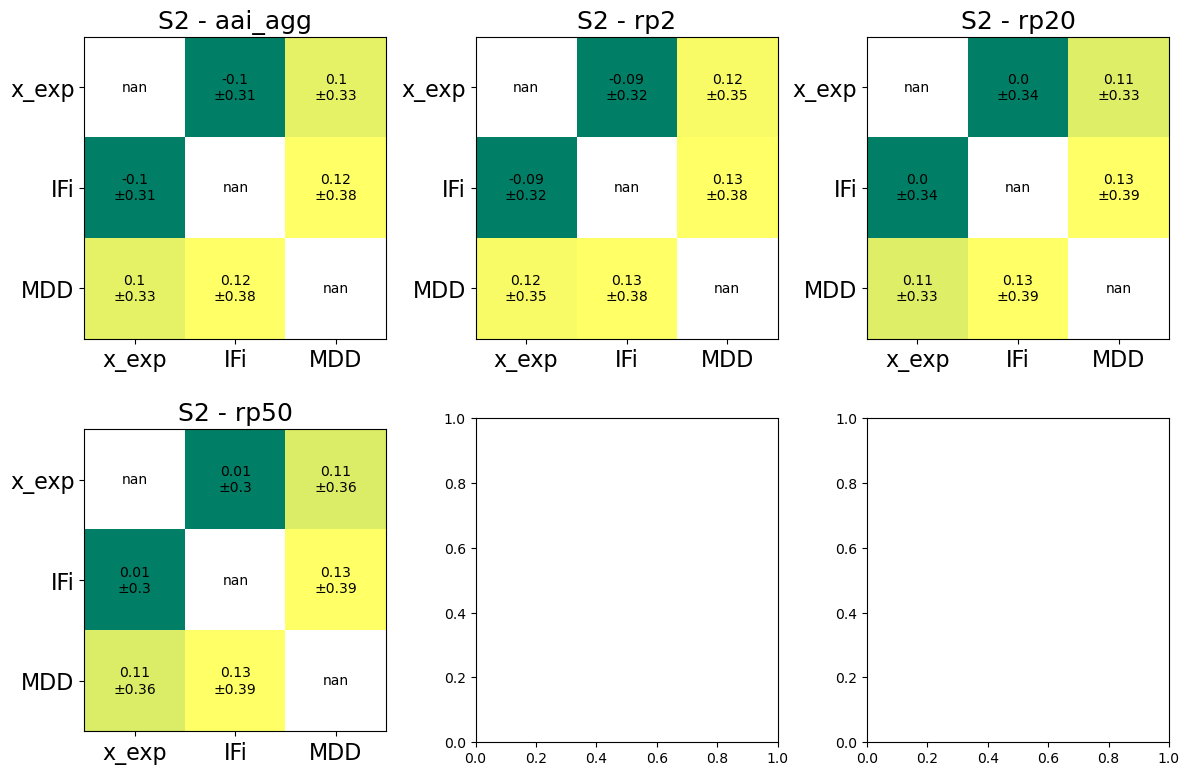

In [60]:
output_imp_sensitivity.plot_sensitivity_second_order(figsize=(12, 8));

The map below indicates the highest sensitivity index for each exposure location based on an analysis of the total impact, taking into account various uncertainties. 

The parameter Mean Degree of Damage "MDD" is the most sensitive in the areas marked in green on the map. In other words, the uncertainty of this parameter has the most significant effect on the mean annual impact in these locations.

The purple colour of "x_exp" on the map indicates that the parameter has the highest first-order sensitivity index ("S1") for most of the exposure locations within the area shown. This means that the mean annual impact at these locations is most sensitive to changes or uncertainty in the "x_exp" parameter. "x_exp" represents a scaling factor for exposure, which adjusts how much the original values increase or decrease. Since it is the most sensitive parameter across all locations, it implies that any variation in "x_exp" will have the most significant effect on the model results, compared to other parameters such as "IFi" (Intensity of Impact Function) or "MDD" (Mean Degree of Damage). This information can be especially useful when prioritizing which parameters to focus on in model calibration or risk mitigation strategies.

c:\users\jimmy\documents\ra\climada_python\climada\engine\unsequa\unc_output.py:400: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_si_idx = si_df_num.idxmax().to_numpy()


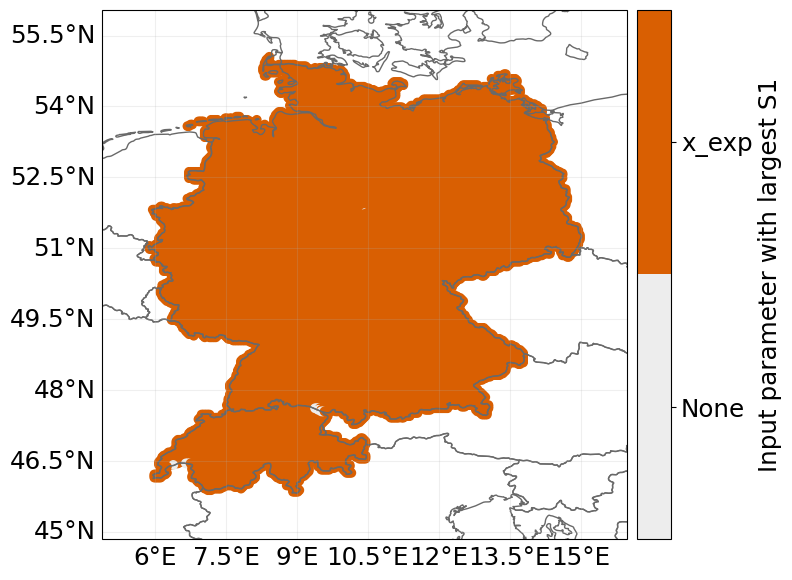

In [61]:
output_imp_sensitivity.plot_sensitivity_map();

### Comparing Deterministic Impact Values (original value of the impacts) with Uncertainty Analysis Outcomes in CLIMADA

Each plot compares the distribution of impact values obtained from the uncertainty analysis (blue bars and blue line for density) against the deterministic (original) values without considering uncertainty (green dotted lines). The orange dashed line represents the average value of the uncertain samples.

In the first plot for aai (top left), the average from uncertainty analysis is slightly lower than the original estimate. In the other three plots for return periods, the averages from the uncertainty analysis are either very close to or slightly higher than the original estimates.

The standard deviation (std) values are minimal (0.13 or 0.12), indicating that while there's uncertainty in the data, the distributions are relatively tight around the mean. When the distribution of values is tight around the mean, it often indicates that the underlying model or system is relatively stable and consistent under the given set of uncertainties being considered. However, it's important to note that even with a tight distribution, the concept of uncertainty is still present. This means that although the majority of the sampled impacts fall near the mean value, the potential for impacts to deviate from this average still exists due to inherent variability.

In [62]:
from climada.engine import ImpactCalc

# Load a default LitPop exposure entity for Switzerland and Germany on the year 2020 (ISO3-Codes 'CHE' and 'DEU'):
try:
    exposure = LitPop.from_countries(
        ["CHE", "DEU"], res_arcsec=120, fin_mode="pop", exponents=(2, 1)
    )
except FileExistsError as err:
    print(
        "Reason for error: The GPW population data has not been downloaded, c.f. section 'Input data' above."
    )
    raise err

# Method is used to assign the centroids of hazard events to the exposure data. This step allows for the association of hazard events with specific population locations.
exposure.assign_centroids(hazard)

imp = ImpactCalc(exposure, if_set_base, hazard).impact(save_mat=True)
aai_agg_o = imp.aai_agg
freq_curve_o = imp.calc_freq_curve([2, 20, 50]).impact
orig_list = [aai_agg_o] + list(freq_curve_o) + [1]

2024-07-17 13:55:19,023 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2024-07-17 13:55:19,048 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2024-07-17 13:55:19,072 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2024-07-17 13:55:19,096 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2024-07-17 13:55:19,107 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2024-07-17 13:55:19,133 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2024-07-17 13:55:19,159 - climada.entity.exposures.litpop.gpw_populati

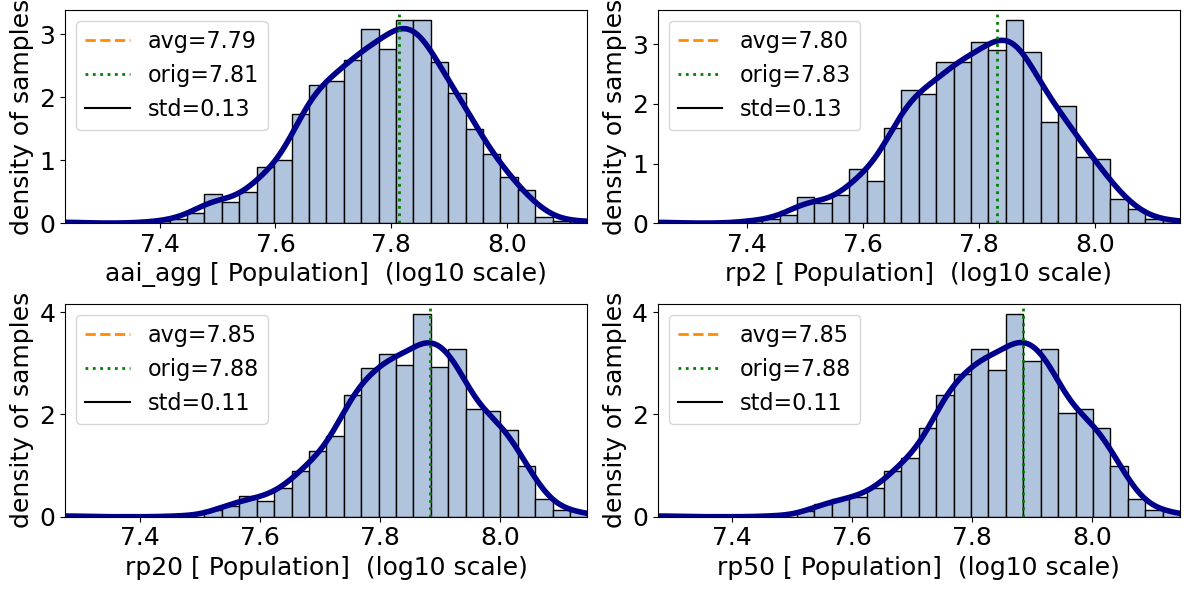

In [63]:
# plot the aai_agg and freq_curve uncertainty only
# use logarithmic x-scale
output_imp_non_linear.plot_uncertainty(
    metric_list=["aai_agg", "freq_curve"],
    orig_list=orig_list,
    log=True,
    figsize=(12, 6),
);